In [3]:
#if the library are not install through command line, you can also go to the kernel > conda package and install
# * pandas
# * matplotlib
# * basemap
#conda install pandas
import numpy as np
import pandas as pd
import datetime
from itertools import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
from matplotlib import mlab
from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt
%matplotlib inline

path_station_boards = 'data/station-boards-dump-4-months.tsv'
path_stops = 'data/stops.txt'

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
print(datetime.datetime.now())
parser = lambda date: pd.datetime.strptime(date, '%a %b %d %Y %H:%M:%S GMT%z (%Z)')

2017-03-22 17:33:27.569533


In [6]:
parser('Sun Mar 27 2016 03:06:55 GMT+0200 (CEST)')

datetime.datetime(2016, 3, 27, 3, 6, 55, tzinfo=datetime.timezone(datetime.timedelta(0, 7200), 'CEST'))

In [15]:
#we restict the analysis to the first 2 millions lines. Head to a more parallel mode (spark to dealing with the entire set)
print(datetime.datetime.now())
df_station_boards = pd.read_csv(path_station_boards,
                            sep='\t',
                            nrows=2000000,
                            parse_dates=[1,4],
                            date_parser=parser
                           ).fillna(0)

2017-03-22 17:35:37.411645


In [16]:
print(datetime.datetime.now())
df_station_boards['delta_mesure'] = df_station_boards.apply(lambda row:(row.timestamp-row.stop_departure).seconds if (row.stop_departure<row.timestamp) else -(row.stop_departure-row.timestamp).seconds, axis=1)/60
df_station_boards['stop_departure_hour'] = df_station_boards.stop_departure.apply(lambda t:t.hour)
df_station_boards['is_delayed'] = df_station_boards.stop_delay.apply(lambda d:d>0)

2017-03-22 17:37:09.948838


In [17]:
print(datetime.datetime.now())
df_station_boards_last = df_station_boards.drop_duplicates(subset='id', keep='last')
df_station_boards_last.head()

2017-03-22 17:42:53.766772


,id,timestamp,stop_station_id,stop_station_name,stop_departure,name,category,operator,to,stop_delay,stop_prognosis_capacity1st,stop_prognosis_capacity2nd,delta_mesure,stop_departure_hour,is_delayed
0,8530011/R 328/Les Ponts-de-Martel/Fri Jan 08 2...,2016-01-08 17:20:04+01:00,8530011,Les Coeudres-Est,2016-01-08 17:20:00+01:00,R 328,R,TRN-cmn,Les Ponts-de-Martel,0.0,-1,-1,0.066667,17,False
1,8530012/R 328/Les Ponts-de-Martel/Fri Jan 08 2...,2016-01-08 17:20:06+01:00,8530012,Petit-Martel-Est,2016-01-08 17:22:00+01:00,R 328,R,TRN-cmn,Les Ponts-de-Martel,0.0,-1,-1,-1.900000,17,False
2,8530064/R 556/Villars-sur-Ollon/Fri Jan 08 201...,2016-01-08 17:05:26+01:00,8530064,Bex Pont-Neuf,2016-01-08 17:09:00+01:00,R 556,R,TPC-bvb,Villars-sur-Ollon,0.0,-1,-1,-3.566667,17,False
3,8530066/R 556/Villars-sur-Ollon/Fri Jan 08 201...,2016-01-08 17:05:27+01:00,8530066,Grand-Moulin,2016-01-08 17:10:00+01:00,R 556,R,TPC-bvb,Villars-sur-Ollon,0.0,-1,-1,-4.550000,17,False
4,8530067/R 556/Villars-sur-Ollon/Fri Jan 08 201...,2016-01-08 17:05:27+01:00,8530067,Les Salines,2016-01-08 17:11:00+01:00,R 556,R,TPC-bvb,Villars-sur-Ollon,0.0,-1,-1,-5.550000,17,False


In [18]:
print(datetime.datetime.now())
#rate of delayed
df_station_boards_delayed=df_station_boards_last[df_station_boards_last['stop_delay']>0]
tot_station_boards = len(df_station_boards_last)
tot_station_boards_delayed = len(df_station_boards_delayed)
tot_station_boards_delayed/tot_station_boards*100

2017-03-22 17:43:02.440961


4.067681168032693

In [19]:
print(datetime.datetime.now())
tot_per_hour = df_station_boards_last.groupby('stop_departure_hour').size()
delayed_per_hour = df_station_boards_delayed.groupby('stop_departure_hour').size()

2017-03-22 17:43:04.790121


2017-03-22 17:35:16.724238


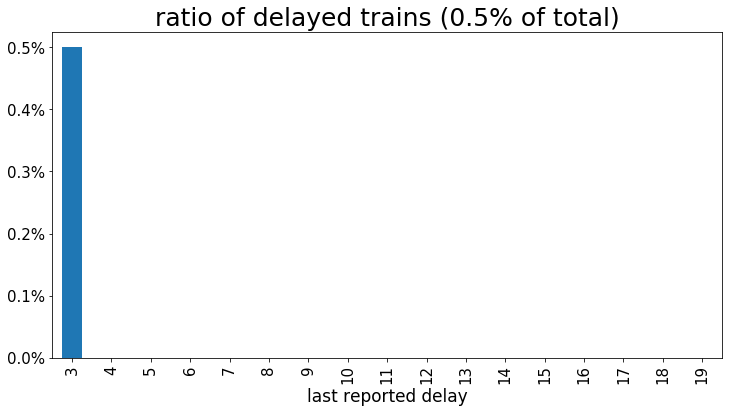

In [13]:
print(datetime.datetime.now())
def to_percent(y, position):
    s = str(100 * y)
    return s + '%'
    
formatter_percent = FuncFormatter(to_percent)

plot_delay_dist = (df_station_boards_delayed.groupby('stop_delay').size()/tot_station_boards)[range(3,20)].plot(kind='bar', figsize=(12,6))
plot_delay_dist.set_xlabel("last reported delay", fontsize=17)
plot_delay_dist.set_title('ratio of delayed trains (%2.1f%% of total)' %(tot_station_boards_delayed/tot_station_boards*100), fontsize=25)
plot_delay_dist.tick_params(axis='both', which='major', labelsize=15)
plot_delay_dist.yaxis.set_major_formatter(formatter_percent)

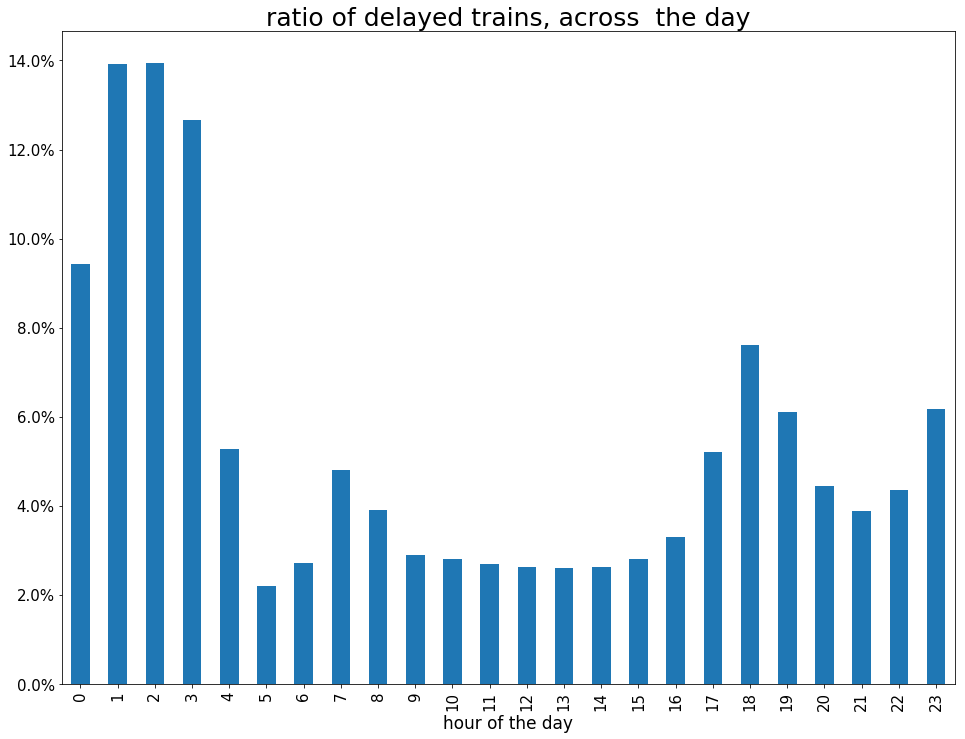

In [20]:
plot_delay_dist = (delayed_per_hour/tot_per_hour).plot(kind='bar', figsize=(16,12))
plot_delay_dist.set_xlabel("hour of the day", fontsize=17)
plot_delay_dist.set_title('ratio of delayed trains, across  the day', fontsize=25)
plot_delay_dist.tick_params(axis='both', which='major', labelsize=15)
plot_delay_dist.yaxis.set_major_formatter(formatter_percent)